In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [2]:
#hyperparameters

#predictive model
layerwidth=50
nblayers=1
activation=nn.Tanh()

#generative model
lat_dim=5



#optimizer
learning_rate=0.005

#scheduler
patience=20
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=1000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=500 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



In [3]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

# Setup #

In [4]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='foong' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=setup.sigma_noise
print(sigma_noise)
sigma_prior=setup.sigma_prior    

size_data=len(train_dataset)
#batch_size
batch_size=20


n_samples_FU=40 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=20 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

0.1


# Predictive model #

In [5]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)



# ELBO

## Average Log Likelihood

In [6]:
#average log likelihood loss
def loss(x_data, y_data, GeN):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise)
    return log_proba.mean()

## Kullback-Leibler divergence in Predictor space

In [7]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
#    epsilon=0.1
    M = 2.#x_train.max(0, keepdim=True)[0]+epsilon
    m = -2.#x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj


#prior on parameters of predictive model

def prior(n):
    return sigma_prior*torch.randn(size=(n,param_count), device=device)


def kl(x_data, GeN):

    theta=GeN(n_samples_KL) #variationnel
    theta_prior=prior(n_samples_KL) #prior

    theta_proj, theta_prior_proj = projection(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

## ELBO ##

In [8]:
#ELBO
def ELBO(x_data, y_data, GeN):
    Average_LogLikelihood=loss(x_data, y_data, GeN)
    the_KL=kl(x_data, GeN)
    the_ELBO= - Average_LogLikelihood+ (len(x_data)/size_data)*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [9]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=151, bias=True)
  )
)


# Optimizer

In [10]:
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)

Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [11]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [12]:
KLs=[]
ELBOs=[]
LLs=[]
LRs=[]

test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'KL_train':[],
              'HMC_OOD':[],
              'HMC_train':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        theta=GeN(1000).detach()
        metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu', std=False)
        metrics.update({'KL_train': kl_train(GeN,x_train[:500]).item()})
        metrics.update({'HMC_OOD': kl_HMC_OOD(GeN).item()})
        metrics.update({'HMC_train': kl_HMC_train(GeN,x_train[:500]).item()})
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN)
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



 19%|█▉        | 194/1000 [00:49<03:26,  3.91it/s, ELBO=12.1, KL=45.2, LogLike=-4.59, lr=0.005]

Epoch   194: reducing learning rate of group 0 to 2.5000e-03.


 31%|███       | 310/1000 [01:18<02:56,  3.92it/s, ELBO=10.4, KL=43.2, LogLike=-3.21, lr=0.0025]

Epoch   310: reducing learning rate of group 0 to 1.2500e-03.


 39%|███▉      | 391/1000 [01:38<02:25,  4.18it/s, ELBO=10.2, KL=41.7, LogLike=-3.21, lr=0.00125]

Epoch   391: reducing learning rate of group 0 to 6.2500e-04.


 43%|████▎     | 433/1000 [01:49<02:25,  3.88it/s, ELBO=9.27, KL=40.8, LogLike=-2.48, lr=0.000625]

Epoch   433: reducing learning rate of group 0 to 3.1250e-04.


 45%|████▌     | 454/1000 [01:54<02:25,  3.75it/s, ELBO=9.46, KL=41.1, LogLike=-2.6, lr=0.000313] 

Epoch   454: reducing learning rate of group 0 to 1.5625e-04.


 50%|█████     | 504/1000 [02:07<02:11,  3.76it/s, ELBO=9.36, KL=40.7, LogLike=-2.58, lr=0.000156]

Epoch   504: reducing learning rate of group 0 to 1.0000e-04.


 50%|█████     | 504/1000 [02:07<02:05,  3.94it/s, ELBO=8.97, KL=39.9, LogLike=-2.32, lr=0.0001]  


In [14]:
%matplotlib inline
fig=setup.makePlotCI(GeN(1000).detach(),device)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--',color='green')


RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 10.76 GiB total capacity; 41.05 MiB already allocated; 28.75 MiB free; 44.00 MiB reserved in total by PyTorch)

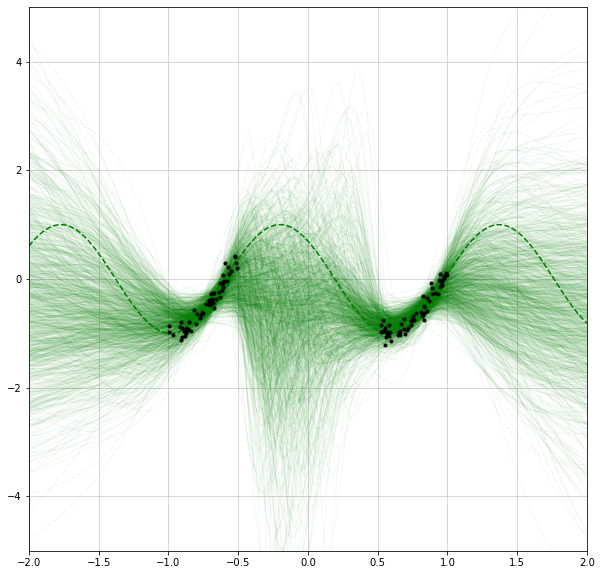

In [15]:
%matplotlib inline
fig=setup.makePlot(GeN(1000).detach(),device)
ax=fig.get_axes()[0]
linspace=torch.linspace(-2,2,200)
ax.plot(linspace, torch.cos(4.0*(linspace+0.2)),'--', color='green')


# Results on test #

In [16]:
#compute metrics on test

results={}
log_device='cpu'
theta=GeN(2000).detach()
metrics=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu')
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})

print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

foong
RMSE: (0.7919421195983887, 0.8445533514022827)
LPP: (-0.8592639151373404, 0.9493411463461222)
PICP: 0.7469388842582703
MPIW: 2.948575735092163
time [s]: 117.08694812981412


In [17]:
#compute metrics on test

results={}
log_device='cpu'
theta=prior(2000).detach()
metrics_=evaluate_metrics(theta, model, x_test, y_test, sigma_noise, std_y_train, device='cpu')
results.update({dataset:metrics_})

print(dataset)
print("prior's scores")
for m, r in metrics_.items():
    print(m+': '+str(r))

foong
prior's scores
RMSE: (0.7109354734420776, 0.6126180291175842)
LPP: (-1.637973747830616, 0.1359540398112626)
PICP: 1.0
MPIW: 7.565591812133789


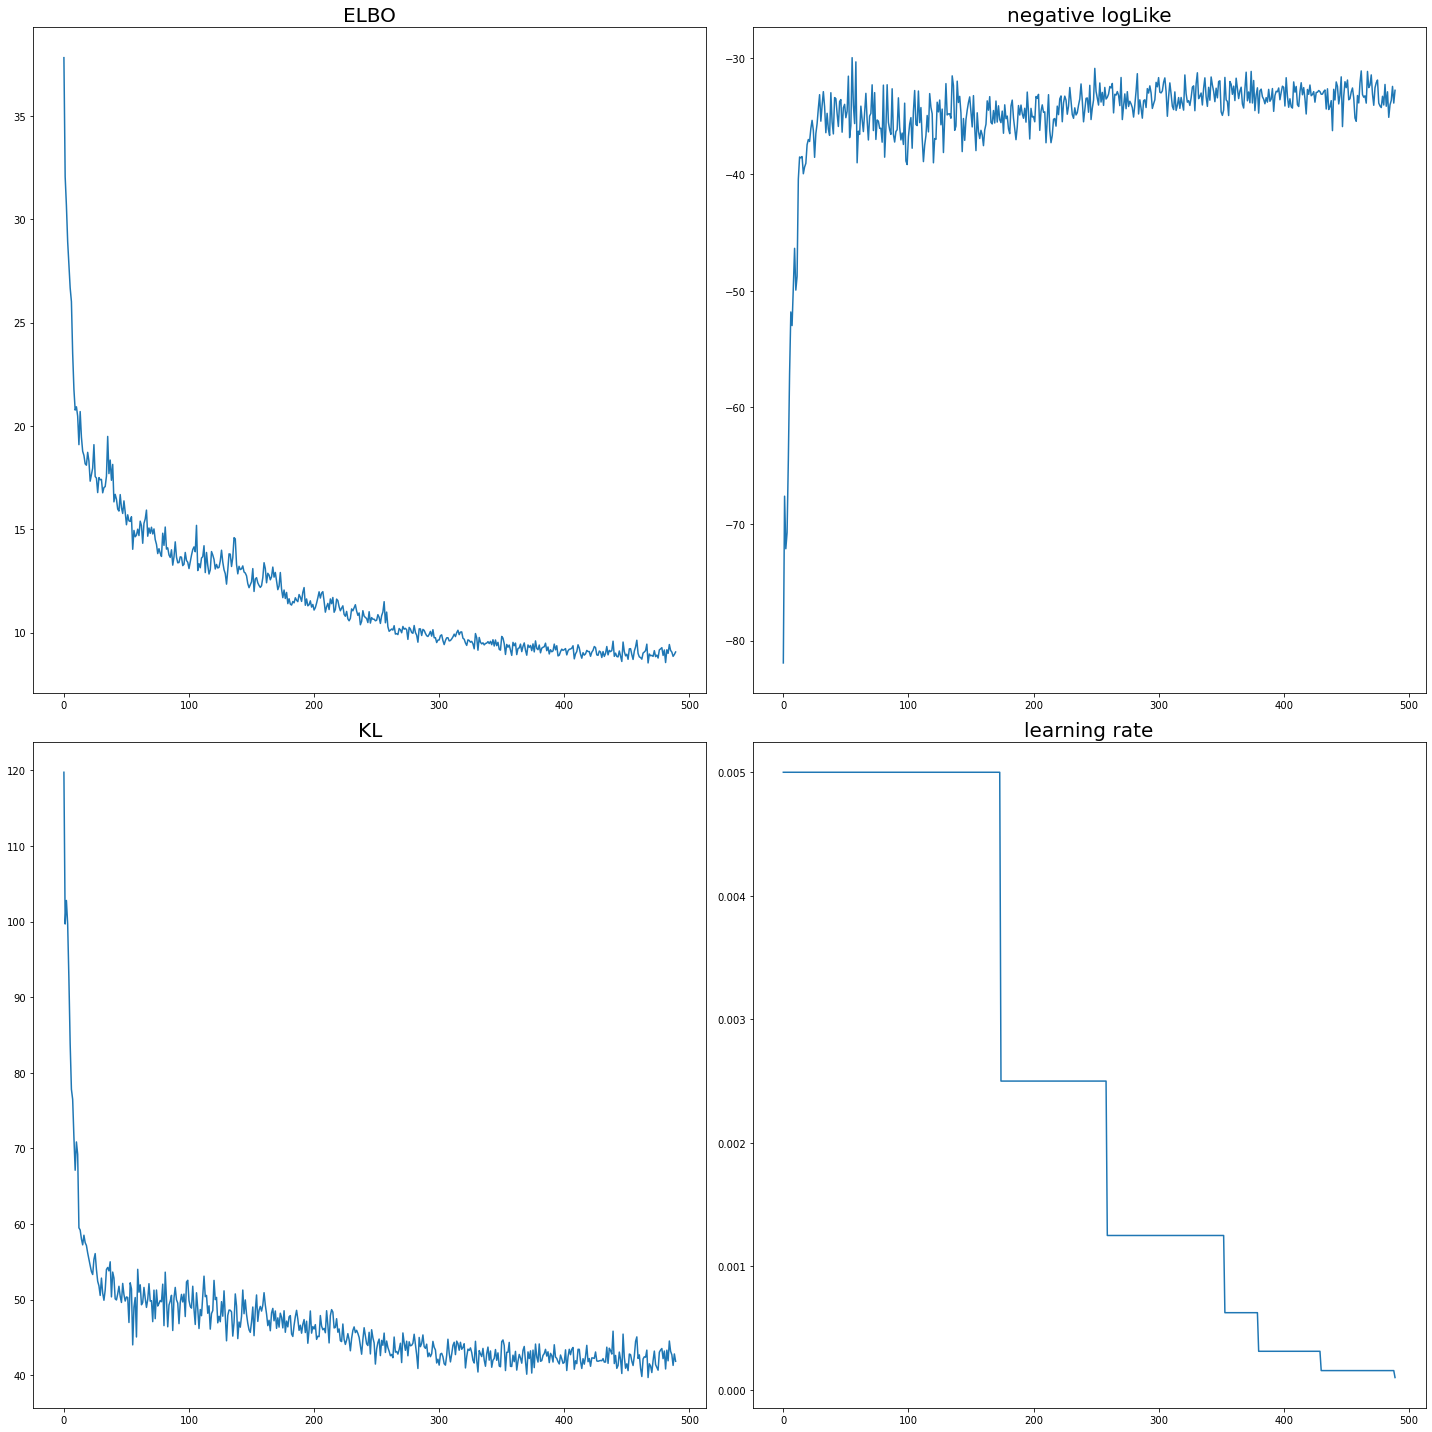

In [18]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LR_=torch.as_tensor(training['LR'])
fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,ELBO_-KL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
fig.tight_layout()

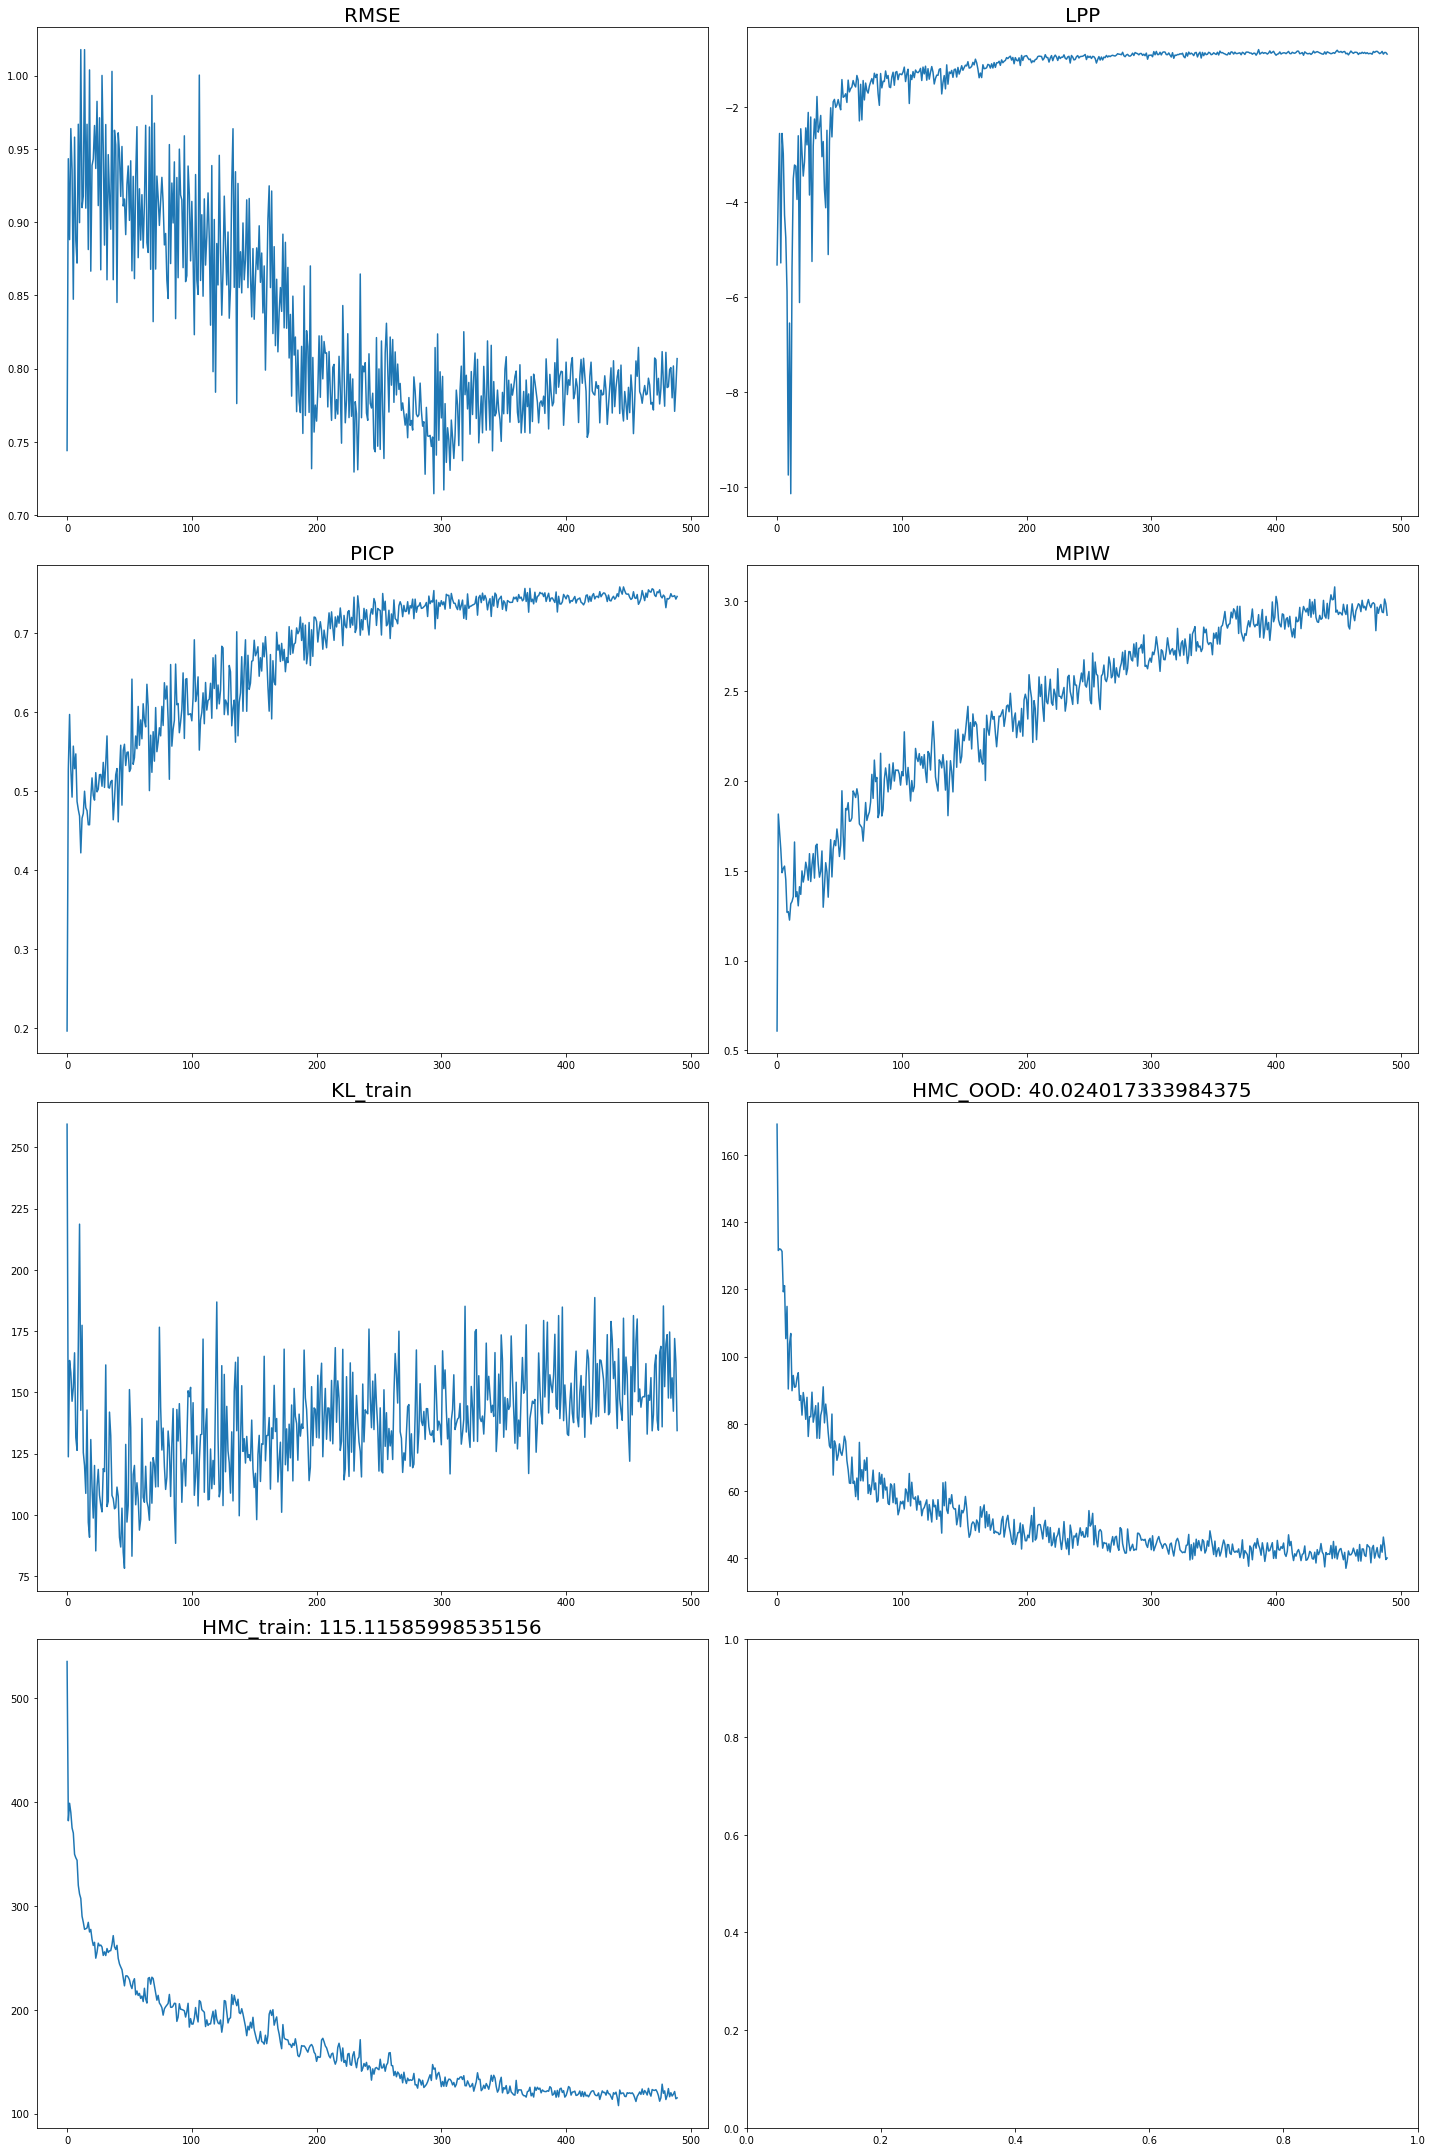

In [19]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(4,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
m='KL_train'
ax[2,0].plot(time_line,test_metrics[m])
ax[2,0].set_title(m, fontsize=20)
m='HMC_OOD'
ax[2,1].plot(time_line,test_metrics[m])
ax[2,1].set_title(m+': '+str(test_metrics[m][-1].item()), fontsize=20)
m='HMC_train'
ax[3,0].plot(time_line,test_metrics[m])
ax[3,0].set_title(m+': '+str(test_metrics[m][-1].item()), fontsize=20)
fig.tight_layout()

In [88]:
from Metrics import FunSW, FunKL
device='cuda:0'

def projection(theta0,theta1, n_input_samples):
    #batch sample OOD   
    n_ood=n_input_samples
    epsilon=0.1
    x_train_=x_train.to(device)
    M = x_train_.max(0, keepdim=True)[0]+epsilon
    m = x_train_.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=X_ood

    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj


def _FunKL(s,t,projection,device):
    k=1
    FKL=FunKL(s,t,projection=projection,device=device,k=k)
    while torch.isinf(FKL):
        k+=1
        FKL=FunKL(s,t,projection=projection,device=device,k=k)
    return FKL


In [89]:
models_HMC = torch.load('Results/HMC_models.pt')
t=models_HMC[dataset].to(device)
s=GeN(t.shape[0]).detach().to(device)
kl_to=_FunKL(s,t,projection,device)
kl_from=_FunKL(t,s,projection,device)
print('KL(-,HMC): '+str(kl_to.item()))
print('KL(HMC,-): '+str(kl_from.item()))

KL(-,HMC): 28.79901123046875
KL(HMC,-): 114.59158325195312
